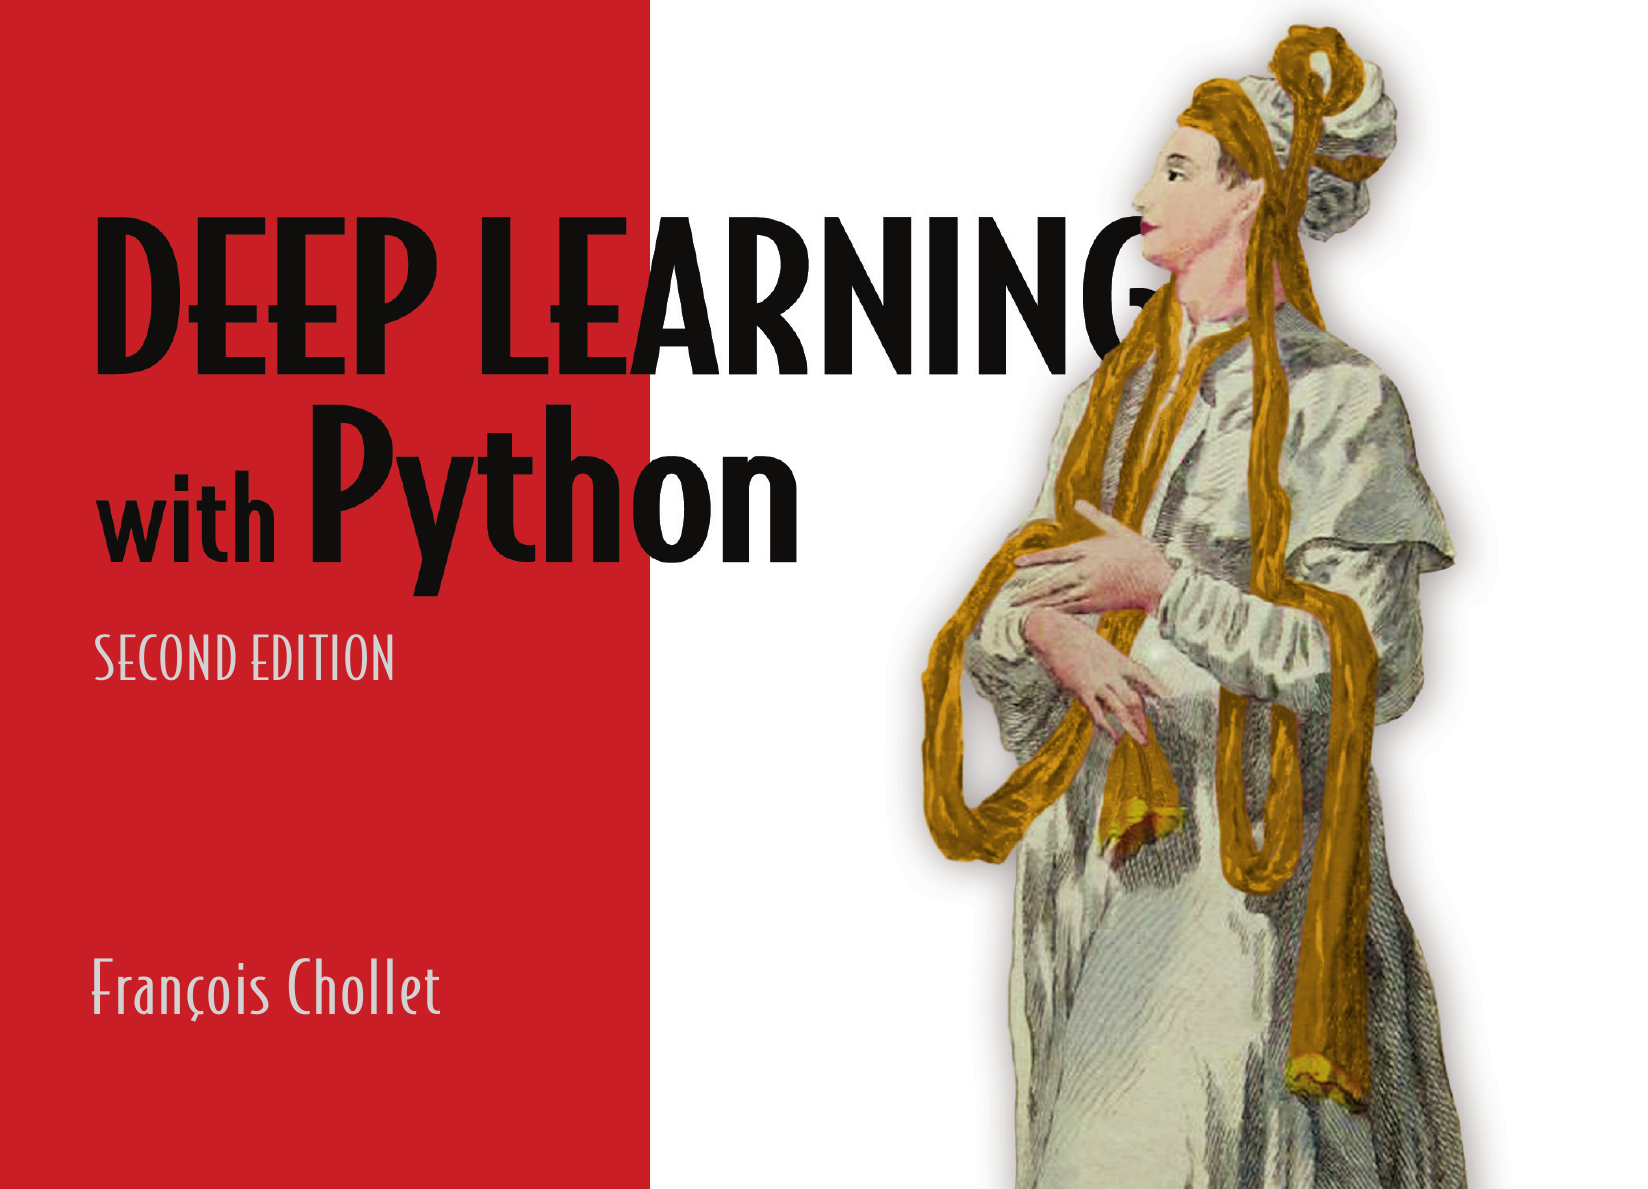

# Introduction to deep learning for computer vision

> ## This chapter covers
>
> * Understanding convolutional neural networks (convnets)
> * Using data augmentation to mitigate overfitting
> * Using a pretrained convnet to do feature extraction
> * Fine-tuning a pretrained convnet

Computer vision is the earliest and biggest success story of deep learning. Every
day, you're interacting with deep vision models—via Google Photos, Google image
search, YouTube, video filters in camera apps, OCR software, and many more.
These models are also at the heart of cutting-edge research in autonomous driving,
robotics, AI-assisted medical diagnosis, autonomous retail checkout systems, and
even autonomous farming.

Computer vision is the problem domain that led to the initial rise of deep learning
between 2011 and 2015. A type of deep learning model called *convolutional neural networks* started getting remarkably good results on image classification
competitions around that time, first with Dan Ciresan winning two niche competitions
(the ICDAR 2011 Chinese character recognition competition and the IJCNN 2011 German traffic signs recognition competition), and then more notably in fall
2012 with Hinton's group winning the high-profile ImageNet large-scale visual recognition
challenge. Many more promising results quickly started bubbling up in other
computer vision tasks.

Interestingly, these early successes weren't quite enough to make deep learning
mainstream at the time—it took a few years. The computer vision research community
had spent many years investing in methods other than neural networks, and it
wasn't quite ready to give up on them just because there was a new kid on the block.
In 2013 and 2014, deep learning still faced intense skepticism from many senior
computer vision researchers. It was only in 2016 that it finally became dominant. I
remember exhorting an ex-professor of mine, in February 2014, to pivot to deep
learning. "It's the next big thing!" I would say. "Well, maybe it's just a fad," he
replied. By 2016, his entire lab was doing deep learning. There's no stopping an
idea whose time has come.

This chapter introduces convolutional neural networks, also known as *convnets*, the
type of deep learning model that is now used almost universally in computer vision
applications. You'll learn to apply convnets to image-classification problems—in particular
those involving small training datasets, which are the most common use case if
you aren't a large tech company.

## Introduction to convnets


We're about to dive into the theory of what convnets are and why they have been so
successful at computer vision tasks. But first, let's take a practical look at a simple convnet
example that classifies MNIST digits, a task we performed in chapter 2 using a
densely connected network (our test accuracy then was 97.8%). Even though the
convnet will be basic, its accuracy will blow our densely connected model from chapter
2 out of the water.

The following listing shows what a basic convnet looks like. It's a stack of ``Conv2d``
and ``MaxPool2d`` layers. You'll see in a minute exactly what they do. We'll build the
model using PyTorch's nn.Module class.

In [1]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 3 * 3, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.softmax(self.fc(x), dim=1)
        return x

model = ConvNet()

Importantly, a convnet takes as input tensors of shape ``(batch_size, image_channels, image_height, image_width)``. In this case, we'll configure the convnet to process inputs of size ``(batch_size, 1, 28, 28)``, which is the format of MNIST images.

Let's display the architecture of our convnet.


In [2]:
print(model)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1152, out_features=10, bias=True)
)


You can see that the output of every ``Conv2d`` and ``MaxPool2d`` layer is a rank-4 tensor
of shape ``(batch_size, channels, height, width)``. The width and height dimensions tend to
shrink as you go deeper in the model. The number of channels is controlled by the
first argument passed to the ``Conv2d`` layers ``(32, 64, or 128)``.

After the last ``Conv2d`` layer, we end up with an output of shape ``(batch_size, 128, 3, 3)``— a ``3 × 3``
feature map of 128 channels. The next step is to feed this output into a densely connected
classifier like those you're already familiar with: a stack of Linear layers. These
classifiers process vectors, which are 1D, whereas the current output is a rank-4 tensor.
To bridge the gap, we flatten the 3D outputs to 1D with a ``Flatten`` layer before adding
the ``Linear`` layers.

Finally, we do 10-way classification, so our last layer has 10 outputs and a softmax
activation.

Now, let's train the convnet on the MNIST digits. We'll reuse a lot of the code from
the MNIST example in chapter 2. Because we're doing 10-way classification with a
softmax output, we'll use the cross entropy loss, and because our labels are
integers, we'll use ``CrossEntropyLoss``.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
                                         download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
                                        download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/5, Loss: {running_loss/len(train_loader):.4f}')

Epoch 1/5, Loss: 1.5778
Epoch 2/5, Loss: 1.4807
Epoch 3/5, Loss: 1.4768
Epoch 4/5, Loss: 1.4740
Epoch 5/5, Loss: 1.4725


Let's evaluate the model on the test data.


In [4]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.990


Whereas the densely connected model from chapter 2 had a test accuracy of 99%,
the basic convnet has a test accuracy of 98.6%: not bad!

But why does this simple convnet work so well, compared to a densely connected
model? To answer this, let's dive into what the ``Conv2d`` and ``MaxPool2d`` layers do.

### The convolutional operation


The fundamental difference between a densely connected layer and a convolution
layer is this: ``Linear`` layers learn global patterns in their input feature space (for example,
for a MNIST digit, patterns involving all pixels), whereas convolution layers learn
local patterns—in the case of images, patterns found in small 2D windows of the
inputs (see figure 8.1). In the previous example, these windows were all 3 × 3.

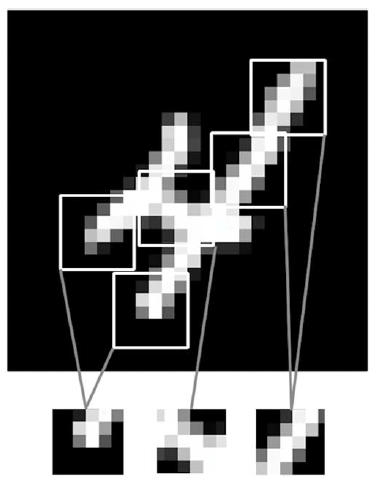

> **Figure 8.1** - Images can be broken into local patterns such as edges, textures, and so on.

This key characteristic gives convnets two interesting properties:

- *The patterns they learn are translation-invariant*. After learning a certain pattern in
the lower-right corner of a picture, a convnet can recognize it anywhere: for
example, in the upper-left corner. A densely connected model would have to
learn the pattern anew if it appeared at a new location. This makes convnets
data-efficient when processing images (because the *visual world is fundamentally translation-invariant*): they need fewer training samples to learn representations
that have generalization power.
- *They can learn spatial hierarchies of patterns*. A first convolution layer will learn
small local patterns such as edges, a second convolution layer will learn larger
patterns made of the features of the first layers, and so on (see figure 8.2). This
allows convnets to efficiently learn increasingly complex and abstract visual concepts,
because *the visual world is fundamentally spatially hierarchical*.

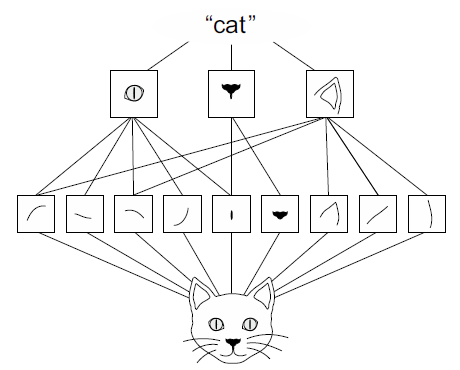

> **Figure 8.2** - The visual world forms a spatial hierarchy of visual modules: elementary lines or textures combine into simple objects such as eyes or ears, which combine into high-level concepts such as "cat".

Convolutions operate over rank-4 tensors called *feature maps*, with a batch dimension,
a depth axis (also called the *channels* axis), and two spatial axes (*height* and *width*). For an RGB
image, the dimension of the depth axis is 3, because the image has three color channels:
red, green, and blue. For a black-and-white picture, like the MNIST digits, the
depth is 1 (levels of gray). The convolution operation extracts patches from its input
feature map and applies the same transformation to all of these patches, producing
an *output feature map*. This output feature map is still a rank-4 tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the
layer, and the different channels in that depth axis no longer stand for specific colors
as in RGB input; rather, they stand for filters. Filters encode specific aspects of the
input data: at a high level, a single filter could encode the concept "presence of a face
in the input," for instance.

In the MNIST example, the first convolution layer takes a feature map of size ``(batch_size, 1, 28, 28)`` and outputs a feature map of size ``(batch_size, 32, 26, 26)``: it computes 32 filters over its
input. Each of these 32 output channels contains a 26 × 26 grid of values, which is a
*response map* of the filter over the input, indicating the response of that filter pattern at
different locations in the input (see figure 8.3).

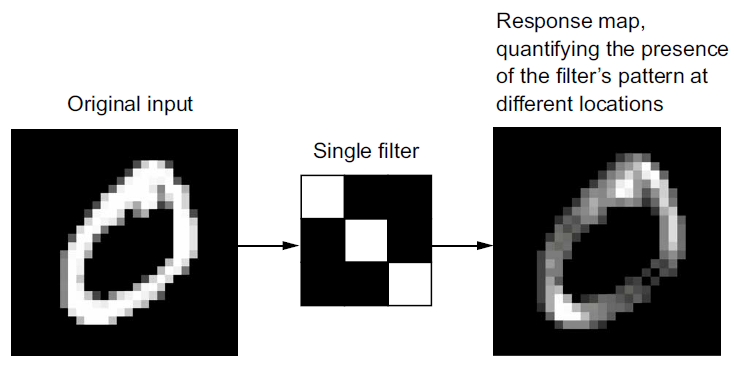

> **Figure 8.3** - The concept of a
> response map: a 2D map of the
> presence of a pattern at different
> locations in an input

That is what the term feature map means: every dimension in the depth axis is a feature
(or filter), and the rank-3 tensor ``output[:, n, :, :]`` is the 2D spatial map of the response
of this filter over the input.

Convolutions are defined by two key parameters:

- *Size of the patches extracted from the inputs*—These are typically ``3 × 3`` or ``5 × 5``. In the
example, they were ``3 × 3``, which is a common choice.
- *Depth of the output feature map*—This is the number of filters computed by the convolution.
The example started with a depth of 32 and ended with a depth of 64.

In PyTorch ``Conv2d`` layers, these parameters are the first arguments passed to the layer:
``Conv2d(input_channels, output_channels, kernel_size)``.

A convolution works by sliding these windows of size ``3 × 3`` or ``5 × 5`` over the 3D
input feature map, stopping at every possible location, and extracting the 3D patch of
surrounding features (shape ``(input_channels, kernel_height, kernel_width)``). Each
such 3D patch is then transformed into a 1D vector of shape ``(output_channels,)``, which is
done via a tensor product with a learned weight matrix, called the convolution kernel—
the same kernel is reused across every patch. All of these vectors (one per patch) are
then spatially reassembled into a 4D output map of shape ``(batch_size, output_channels, height, width)``.
Every spatial location in the output feature map corresponds to the same
location in the input feature map (for example, the lower-right corner of the output
contains information about the lower-right corner of the input).
For instance, with ``3 × 3`` windows, the vector output ``[:, :, i, j]`` comes from the 3D patch input ``[:, :, i-1:i+1, j-1:j+1]``. The full process is detailed in figure 8.4.

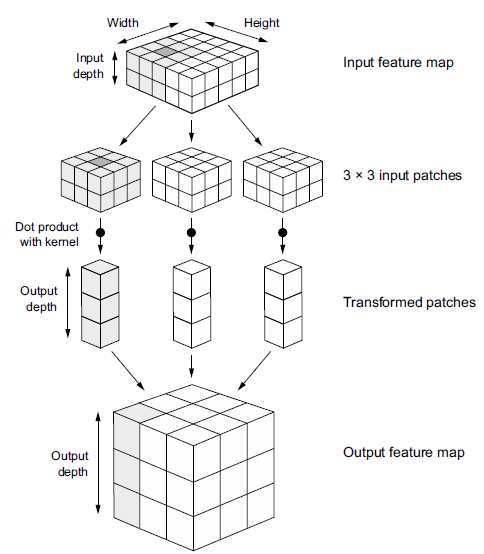

> **Figure 8.4** - How convolution works

Note that the output width and height may differ from the input width and height for
two reasons:
- Border effects, which can be countered by padding the input feature map
- The use of strides, which I'll define in a second

Let's take a deeper look at these notions.

#### UNDERSTANDING BORDER EFFECTS AND PADDING

Consider a ``5 × 5`` feature map (25 tiles total). There are only 9 tiles around which you
can center a ``3 × 3`` window, forming a ``3 × 3`` grid (see figure 8.5). Hence, the output feature
map will be ``3 × 3``. It shrinks a little: by exactly two tiles alongside each dimension,
in this case. You can see this border effect in action in the earlier example: you start
with 28 × 28 inputs, which become ``26 × 26`` after the first convolution layer.


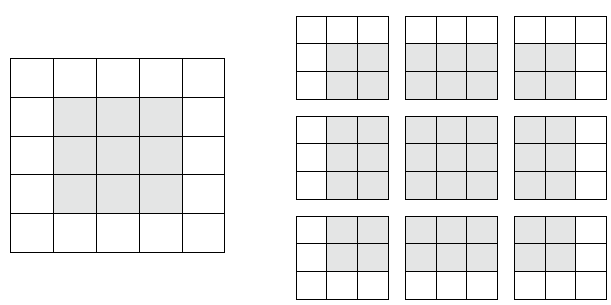

> **Figure 8.5** - Valid locations of 3 x 3 patches in a 5 x 5 input feature map

If you want to get an output feature map with the same spatial dimensions as the
input, you can use padding. Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center
convolution windows around every input tile. For a ``3 × 3`` window, you add one column
on the right, one column on the left, one row at the top, and one row at the
bottom. For a ``5 × 5`` window, you add two rows (see figure 8.6).

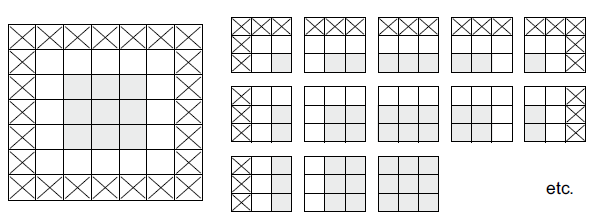

> **Figure 8.6** - Padding a 5 x 5 input in order to be able to extract 25 3 x 3 patches

In ``Conv2d`` layers, padding is configurable via the ``padding`` argument, which takes
integer values: ``0`` means no padding (only valid window locations will be used),
and ``1`` means "pad by one pixel on each side to have an output with the same width
and height as the input." The ``padding`` argument defaults to ``0``.

#### UNDERSTANDING CONVOLUTION STRIDES

The other factor that can influence output size is the notion of *strides*. Our description
of convolution so far has assumed that the center tiles of the convolution windows are
all contiguous. But the distance between two successive windows is a parameter of the convolution, called its stride, which defaults to 1. It's possible to have *strided convolutions*:
convolutions with a stride higher than 1. In figure 8.7, you can see the patches
extracted by a ``3 × 3`` convolution with stride 2 over a ``5 × 5`` input (without padding).

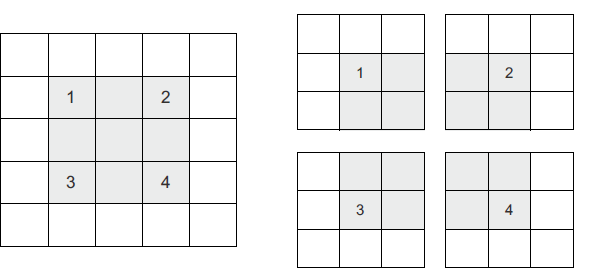

> **Figure 8.7** - 3 x 3 convolution patches with 2 x 2 strides

Using stride 2 means the width and height of the feature map are downsampled by a
factor of 2 (in addition to any changes induced by border effects). Strided convolutions
are rarely used in classification models, but they come in handy for some types of
models, as you will see in the next chapter.

In classification models, instead of strides, we tend to use the *max-pooling* operation
to downsample feature maps, which you saw in action in our first convnet example.

Let's look at it in more depth.

### The max-pooling operation


In the convnet example, you may have noticed that the size of the feature maps is
halved after every ``MaxPool2d`` layer. For instance, before the first ``MaxPool2d`` layers,
the feature map is ``26 × 26``, but the max-pooling operation halves it to ``13 × 13``.
That's the role of max pooling: to aggressively downsample feature maps, much like
strided convolutions.

Max pooling consists of extracting windows from the input feature maps and
outputting the max value of each channel. It's conceptually similar to convolution,
except that instead of transforming local patches via a learned linear transformation
(the convolution kernel), they're transformed via a hardcoded ``max`` tensor
operation. A big difference from convolution is that max pooling is usually done
with ``2 × 2`` windows and stride 2, in order to downsample the feature maps by a factor
of 2. On the other hand, convolution is typically done with ``3 × 3`` windows and no
stride (stride 1).

Why downsample feature maps this way? Why not remove the max-pooling layers
and keep fairly large feature maps all the way up? Let's look at this option. Our model
would then look like the following listing.

In [5]:
class ConvNetNoMaxPool(nn.Module):
    def __init__(self):
        super(ConvNetNoMaxPool, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 22 * 22, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.softmax(self.fc(x), dim=1)
        return x

model_no_max_pool = ConvNetNoMaxPool()

Here's a summary of the model:


In [6]:
print(model_no_max_pool)


ConvNetNoMaxPool(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=61952, out_features=10, bias=True)
)


What's wrong with this setup? Two things:
- It isn't conducive to learning a spatial hierarchy of features. The ``3 × 3`` windows
in the third layer will only contain information coming from ``7 × 7`` windows in
the initial input. The high-level patterns learned by the convnet will still be very
small with regard to the initial input, which may not be enough to learn to classify
digits (try recognizing a digit by only looking at it through windows that are
``7 × 7`` pixels!). We need the features from the last convolution layer to contain
information about the totality of the input.
- The final feature map has ``22 × 22 × 128 = 61,952`` total coefficients per sample.
This is huge. When you flatten it to stick a ``Linear`` layer of size 10 on top, that
layer would have over half a million parameters. This is far too large for such a
small model and would result in intense overfitting.

In short, the reason to use downsampling is to reduce the number of feature-map
coefficients to process, as well as to induce spatial-filter hierarchies by making successive
convolution layers look at increasingly large windows (in terms of the fraction of
the original input they cover).

Note that max pooling isn't the only way you can achieve such downsampling. As
you already know, you can also use strides in the prior convolution layer. And you can
use average pooling instead of max pooling, where each local input patch is transformed
by taking the average value of each channel over the patch, rather than the
max. But max pooling tends to work better than these alternative solutions. The reason
is that features tend to encode the spatial presence of some pattern or concept
over the different tiles of the feature map (hence the term *feature map*), and it's more
informative to look at the *maximal presence* of different features than at their *average presence*. The most reasonable subsampling strategy is to first produce dense maps of
features (via unstrided convolutions) and then look at the maximal activation of the
features over small patches, rather than looking at sparser windows of the inputs (via
strided convolutions) or averaging input patches, which could cause you to miss or
dilute feature-presence information.

At this point, you should understand the basics of convnets—feature maps, convolution,
and max pooling—and you should know how to build a small convnet to solve
a toy problem such as MNIST digits classification. Now let's move on to more useful,
practical applications.

## Training a convnet from scratch on a small dataset


Having to train an image-classification model using very little data is a common situation,
which you'll likely encounter in practice if you ever do computer vision in a
professional context. A "few" samples can mean anywhere from a few hundred to a
few tens of thousands of images. As a practical example, we'll focus on classifying
images as dogs or cats in a dataset containing 5,000 pictures of cats and dogs (2,500
cats, 2,500 dogs). We'll use 2,000 pictures for training, 1,000 for validation, and
2,000 for testing.

In this section, we'll review one basic strategy to tackle this problem: training a new
model from scratch using what little data you have. We'll start by naively training a
small convnet on the 2,000 training samples, without any regularization, to set a baseline
for what can be achieved. This will get us to a classification accuracy of about
70%. At that point, the main issue will be overfitting. Then we'll introduce *data augmentation*,
a powerful technique for mitigating overfitting in computer vision. By using
data augmentation, we'll improve the model to reach an accuracy of 80–85%.

In the next section, we'll review two more essential techniques for applying deep
learning to small datasets: *feature extraction with a pretrained model* (which will get us to
an accuracy of 96.7%) and *fine-tuning a pretrained model* (which will get us to a final accuracy
of 98.4%). Together, these three strategies—training a small model from scratch,
doing feature extraction using a pretrained model, and fine-tuning a pretrained model—will constitute your future toolbox for tackling the problem of performing
image classification with small datasets.

### The relevance of deep learning for small-data problems


What qualifies as "enough samples" to train a model is relative—relative to the size
and depth of the model you're trying to train, for starters. It isn't possible to train a
convnet to solve a complex problem with just a few tens of samples, but a few hundred
can potentially suffice if the model is small and well regularized and the task is simple.
Because convnets learn local, translation-invariant features, they're highly data-efficient
on perceptual problems. Training a convnet from scratch on a very small image dataset
will yield reasonable results despite a relative lack of data, without the need for any
custom feature engineering. You'll see this in action in this section.

What's more, deep learning models are by nature highly repurposable: you can
take, say, an image-classification or speech-to-text model trained on a large-scale dataset
and reuse it on a significantly different problem with only minor changes. Specifically,
in the case of computer vision, many pretrained models (usually trained on the
ImageNet dataset) are now publicly available for download and can be used to bootstrap
powerful vision models out of very little data. This is one of the greatest
strengths of deep learning: feature reuse. You'll explore this in the next section.

Let's start by getting our hands on the data.

### Downloading the data


The Dogs vs. Cats dataset that we will use isn't packaged with PyTorch. It was made available
by Kaggle as part of a computer vision competition in late 2013, back when convnets
weren't mainstream. You can download the original dataset from [www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data) (you'll need to create a Kaggle account if you don't already
have one—don't worry, the process is painless). You can also use the Kaggle API to
download the dataset in Colab (see the "Downloading a Kaggle dataset in Google
Colaboratory" sidebar).


> #### Downloading a Kaggle dataset in Google Colaboratory
> 
> Kaggle makes available an easy-to-use API to programmatically download Kagglehosted
> datasets. You can use it to download the Dogs vs. Cats dataset to a Colab
> notebook, for instance. This API is available as the ``kaggle`` package, which is preinstalled
> on Colab. Downloading this dataset is as easy as running the following command
> in a Colab cell:
> 
> ```bash
> !kaggle competitions download -c dogs-vs-cats
> ```
> 
> However, access to the API is restricted to Kaggle users, so in order to run the preceding
> command, you first need to authenticate yourself. The ``kaggle`` package will
> look for your login credentials in a JSON file located at ``~/.kaggle/kaggle.json``. Let's
> create this file.
> 
> First, you need to create a Kaggle API key and download it to your local machine. Just
> navigate to the Kaggle website in a web browser, log in, and go to the My Account
> page. In your account settings, you'll find an API section. Clicking the Create New API
> Token button will generate a ``kaggle.json`` key file and will download it to your machine.
> 
> Second, go to your Colab notebook, and upload the API's key JSON file to your Colab
> session by running the following code in a notebook cell:
> 
> ```python
> from google.colab import files
> files.upload()
> ```
> 
> When you run this cell, you will see a Choose Files button appear. Click it and select
> the kaggle.json file you just downloaded. This uploads the file to the local Colab runtime.
> 
> Finally, create a ``~/.kaggle`` folder (``mkdir ~/.kaggle``), and copy the key file to it
> (``cp kaggle.json ~/.kaggle/``). As a security best practice, you should also make
> sure that the file is only readable by the current user, yourself (``chmod 600``):
> 
> ```bash
> !mkdir ~/.kaggle
> !cp kaggle.json ~/.kaggle/
> !chmod 600 ~/.kaggle/kaggle.json
> ```
> 
> You can now download the data we're about to use:
> 
> ```bash
> !kaggle competitions download -c dogs-vs-cats
> ```
> 
> The first time you try to download the data, you may get a "403 Forbidden" error.
> That's because you need to accept the terms associated with the dataset before you
> download it—you'll have to go to [www.kaggle.com/c/dogs-vs-cats/rules](https://www.kaggle.com/c/dogs-vs-cats/> rules) (while
> logged into your Kaggle account) and click the **I Understand and Accept** button. You
> only need to do this once.
> 
> Finally, the training data is a compressed file named train.zip. Make sure you uncompress
> it (``unzip``) silently (``-qq``):
> 
> ```bash
> !unzip -qq train.zip
> ```

The pictures in our dataset are medium-resolution color JPEGs. Figure 8.8 shows
some examples.

Unsurprisingly, the original dogs-versus-cats Kaggle competition, all the way back
in 2013, was won by entrants who used convnets. The best entries achieved up to 95%
accuracy. In this example, we will get fairly close to this accuracy (in the next section),
even though we will train our models on less than 10% of the data that was available to
the competitors.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and
is 543 MB (compressed). After downloading and uncompressing the data, we'll create
a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each
class. Why do this? Because many of the image datasets you'll encounter in your
career only contain a few thousand samples, not tens of thousands. Having more data
available would make the problem easier, so it's good practice to learn with a small
dataset.

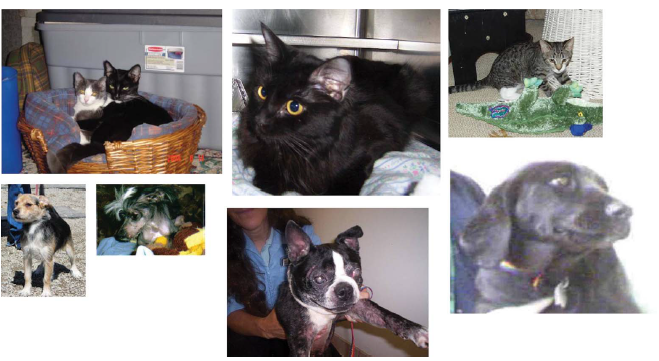

> **Figure 8.8** - Samples from the Dogs vs. Cats dataset. Sizes weren't modified: the samples come in different sizes, colors, backgrounds, etc.

The subsampled dataset we will work with will have the following directory structure:

```
cats_vs_dogs_small/
...train/
......cat/
......dog/
...validation/
......cat/
......dog/
...test/
......cat/
......dog/
```

Let's make it happen in a couple calls to ``shutil``.

In [2]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [ ]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

We now have 2,000 training images, 1,000 validation images, and 
2,000 test images.
Each split contains the same number of samples from each class: this is a balanced
binary-classification problem, which means classification accuracy will be an appropriate
measure of success.

### Building the model


We will reuse the same general model structure you saw in the first example: the convnet
will be a stack of alternated ``Conv2d`` (with ``relu`` activation) and ``MaxPool2d`` layers.

But because we're dealing with bigger images and a more complex problem, we'll
make our model larger, accordingly: it will have two more ``Conv2d`` and ``MaxPool2d``
stages. This serves both to augment the capacity of the model and to further reduce the
size of the feature maps so they aren't overly large when we reach the ``Flatten`` layer.
Here, because we start from inputs of size 180 pixels × 180 pixels (a somewhat arbitrary
choice), we end up with feature maps of size ``7 × 7`` just before the ``Flatten`` layer.

> **NOTE**  The depth of the feature maps progressively increases in the model
> (from 32 to 256), whereas the size of the feature maps decreases (from 180 ×
> 180 to ``7 × 7``). This is a pattern you'll see in almost all convnets.

Because we're looking at a binary-classification problem, we'll end the model with a
single unit (a ``Linear`` layer of size 1) and a ``sigmoid`` activation. This unit will encode the
probability that the model is looking at one class or the other.

One last small difference: we will start the model with normalization that will
rescale image inputs (whose values are originally in the ``[0, 255]`` range) to the ``[0, 1]`` range.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CatsDogsConvNet(nn.Module):
    def __init__(self):
        super(CatsDogsConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 7 * 7, 1)
    
    def forward(self, x):
        x = x / 255.0
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = F.relu(self.conv5(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x.view(-1)

model = CatsDogsConvNet()

Let's look at how the dimensions of the feature maps change with every successive
layer:

In [29]:
print(model)


CatsDogsConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
)


For the compilation step, we'll go with the ``RMSprop`` optimizer, as usual. Because we
ended the model with a single sigmoid unit, we'll use binary cross entropy as the loss
(as a reminder, check out table 6.1 in chapter 6 for a cheat sheet on which loss function
to use in various situations).

In [ ]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

### Data preprocessing


As you know by now, data should be formatted into appropriately preprocessed floatingpoint
tensors before being fed into the model. Currently, the data sits on a drive as
JPEG files, so the steps for getting it into the model are roughly as follows:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (we'll use ``180 × 180``).
5. Pack them into batches (we'll use batches of 32 images).

It may seem a bit daunting, but fortunately PyTorch has utilities to take care of these steps
automatically. In particular, PyTorch features the utility class ``ImageFolder`` from ``torchvision.datasets``, which lets you quickly set up a data pipeline that can automatically turn
image files on disk into batches of preprocessed tensors. This is what we'll use here.

Using ``ImageFolder`` will first list the subdirectories
of the directory and assume each one contains images from one of our classes. It will
then index the image files in each subdirectory. Finally, it will create and return a
``Dataset`` object configured to read these files, decode them to
tensors, resize them to a shared size, and pack them into batches when used with a ``DataLoader``.

In [49]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255)  # Convert back to [0, 255] range for our model
])

train_dataset = torchvision.datasets.ImageFolder(
    root=new_base_dir / "train",
    transform=transform
)

validation_dataset = torchvision.datasets.ImageFolder(
    root=new_base_dir / "validation", 
    transform=transform
)

test_dataset = torchvision.datasets.ImageFolder(
    root=new_base_dir / "test",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#### Understanding PyTorch ``Dataset`` and ``DataLoader`` objects


PyTorch makes available the ``torch.utils.data`` API to create efficient input pipelines for
machine learning models. Its core classes are ``Dataset`` and ``DataLoader``.

A ``DataLoader`` object is an iterator: you can use it in a ``for`` loop. It will typically return
batches of input data and labels. You can pass batches from a ``DataLoader`` to train a PyTorch model.

The ``DataLoader`` class handles many key features that would otherwise be cumbersome
to implement yourself—in particular, asynchronous data prefetching (preprocessing
the next batch of data while the previous one is being handled by the model, which
keeps execution flowing without interruptions).

The ``Dataset`` and ``DataLoader`` classes also expose a functional-style API for modifying datasets. Here's
a quick example: let's create a ``Dataset`` instance from a NumPy array of random numbers.
We'll consider 1,000 samples, where each sample is a vector of size 16:

In [13]:
import numpy as np
from torch.utils.data import TensorDataset

random_numbers = np.random.normal(size=(1000, 16))
dataset = TensorDataset(torch.from_numpy(random_numbers).float())


At first, our dataset yields single samples:


In [14]:
for i, element in enumerate(dataset):
    print(element[0].shape)
    if i >= 2:
        break

torch.Size([16])
torch.Size([16])
torch.Size([16])


We can use a ``DataLoader`` to batch the data:


In [15]:
dataloader = DataLoader(dataset, batch_size=32)
for i, element in enumerate(dataloader):
    print(element[0].shape)
    if i >= 2:
        break

torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])


More broadly, we have access to a range of useful dataset methods and transforms, such as
- ``transforms.RandomHorizontalFlip()``—Randomly flips images horizontally
- ``DataLoader(..., num_workers=4)``—Uses multiple workers for faster data loading
- Various transforms in ``torchvision.transforms`` for data preprocessing and augmentation

Let's look at the output of one of these ``DataLoader`` objects: it yields batches of ``180 × 180``
RGB images (shape ``(32, 3, 180, 180)``) and integer labels (shape ``(32,)``). There are
32 samples in each batch (the batch size).

In [16]:
for data_batch, labels_batch in train_loader:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: torch.Size([32, 3, 180, 180])
labels batch shape: torch.Size([32])


Let's fit the model on our dataset. We'll monitor validation metrics on a separate ``DataLoader`` object.

Note that we'll also save the model after each epoch when the validation loss improves. We'll implement this manually since PyTorch doesn't have a built-in callback system like TensorFlow/Keras.

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def calculate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)#.squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = calculate_accuracy(train_loader, model, device)
    val_acc = calculate_accuracy(validation_loader, model, device)

    # Evaluate each epoch
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)#.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(validation_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/30, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "convnet_from_scratch.pth")


Epoch 1/30, Train Loss: 0.6859, Train Acc: 0.5000, Val Loss: 0.7677, Val Acc: 0.5000
Epoch 2/30, Train Loss: 0.6838, Train Acc: 0.5505, Val Loss: 0.6609, Val Acc: 0.5410
Epoch 3/30, Train Loss: 0.6871, Train Acc: 0.5030, Val Loss: 0.6648, Val Acc: 0.5040
Epoch 4/30, Train Loss: 0.6552, Train Acc: 0.5755, Val Loss: 0.6391, Val Acc: 0.5690
Epoch 5/30, Train Loss: 0.6551, Train Acc: 0.6250, Val Loss: 0.6138, Val Acc: 0.6120
Epoch 6/30, Train Loss: 0.6224, Train Acc: 0.6110, Val Loss: 0.6148, Val Acc: 0.5950
Epoch 7/30, Train Loss: 0.6061, Train Acc: 0.6390, Val Loss: 0.8327, Val Acc: 0.6300
Epoch 8/30, Train Loss: 0.5977, Train Acc: 0.7160, Val Loss: 0.6156, Val Acc: 0.6930
Epoch 9/30, Train Loss: 0.5689, Train Acc: 0.7025, Val Loss: 0.5963, Val Acc: 0.6370
Epoch 10/30, Train Loss: 0.5382, Train Acc: 0.6870, Val Loss: 0.5797, Val Acc: 0.6290
Epoch 11/30, Train Loss: 0.5150, Train Acc: 0.7895, Val Loss: 0.5701, Val Acc: 0.7150
Epoch 12/30, Train Loss: 0.4752, Train Acc: 0.8115, Val Loss: 0

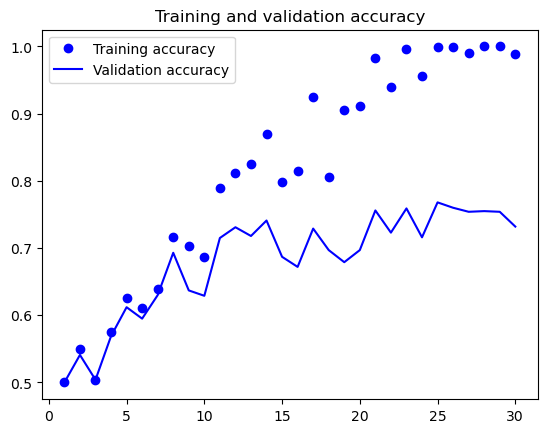

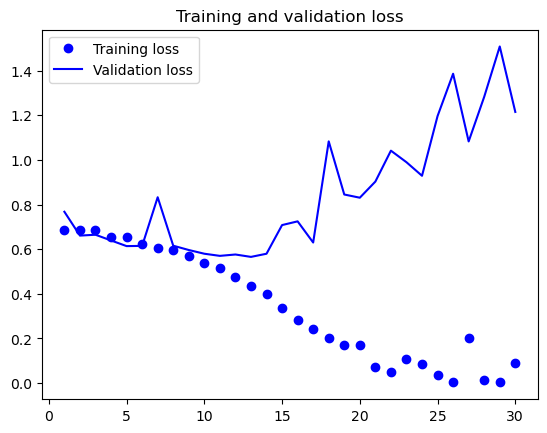

In [53]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, train_losses, "bo", label="Training loss")
plt.plot(epochs, val_losses, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

> **Figure 8.9** - Training and validation metrics for a simple convnet

These plots are characteristic of overfitting. The training accuracy increases linearly
over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%.
The validation loss reaches its minimum after only ten epochs and then stalls, whereas
the training loss keeps decreasing linearly as training proceeds.

Let's check the test accuracy. We'll reload the model from its saved file to evaluate
it as it was before it started overfitting.

In [54]:
model.load_state_dict(torch.load("convnet_from_scratch.pth"))
test_acc = calculate_accuracy(test_loader, model, device)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.714


We get a test accuracy of nearly 70%. (Due to the randomness of neural network initializations,
you may get numbers within one percentage point of that.)

Because we have relatively few training samples (2,000), overfitting will be our
number one concern. You already know about a number of techniques that can help
mitigate overfitting, such as dropout and weight decay (L2 regularization). We're now
going to work with a new one, specific to computer vision and used almost universally
when processing images with deep learning models: *data augmentation*.

### Using data augmentation


Overfitting is caused by having too few samples to learn from, rendering you unable
to train a model that can generalize to new data. Given infinite data, your model
would be exposed to every possible aspect of the data distribution at hand: you would
never overfit. Data augmentation takes the approach of generating more training data
from existing training samples by *augmenting* the samples via a number of random
transformations that yield believable-looking images. The goal is that, at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data so it can generalize better.

In PyTorch, this can be done by adding a number of *data augmentation transforms* to
your data preprocessing pipeline. Let's get started with an example: the following transforms
chain several random image transformations. In our model, we'd include it in our
training dataset transform.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=36),  # 10% of 360 degrees
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),  # Random zoom
    transforms.ToTensor(),
])

# No augmentation for validation/test
val_test_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
])

These are just a few of the transforms available (for more, see the PyTorch documentation).
Let's quickly go over this code:

- RandomHorizontalFlip(p=0.5)—Applies horizontal flipping to a random 50% of
the images that go through it
- RandomRotation(degrees=36)—Rotates the input images by a random value in the range
[–36 degrees, +36 degrees] (equivalent to [–10%, +10%] of a full circle)
- RandomAffine(degrees=0, scale=(0.8, 1.2))—Zooms in or out of the image by a random factor in the
range [80%, 120%] (equivalent to [-20%, +20%])

Let's look at the augmented images (see figure 8.10).

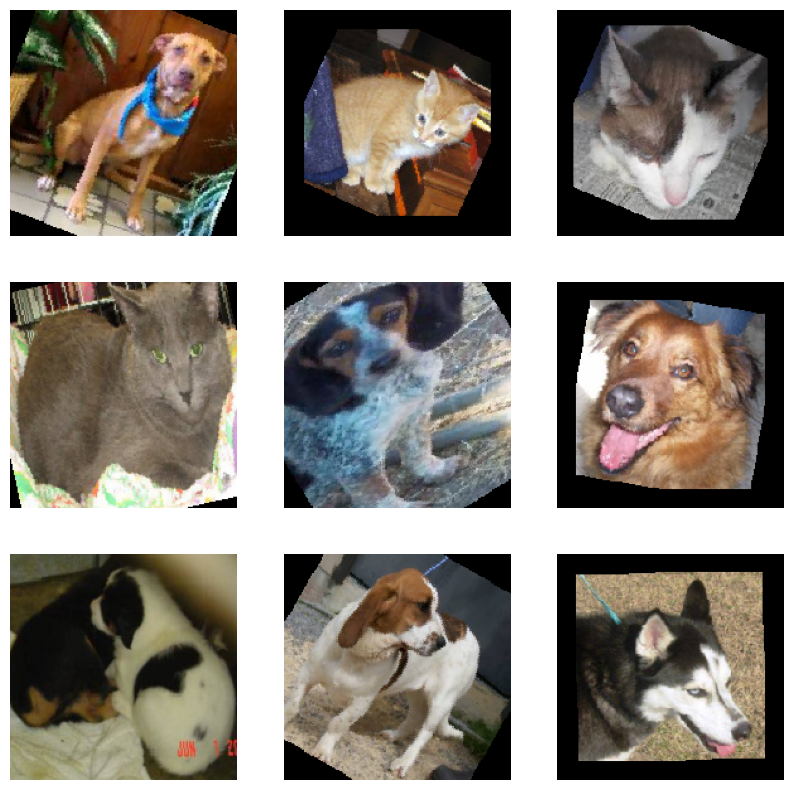

In [60]:
import matplotlib.pyplot as plt

augmented_dataset = torchvision.datasets.ImageFolder(
    root=new_base_dir / "train",
    transform=train_transform
)
augmented_loader = DataLoader(augmented_dataset, batch_size=1, shuffle=True)

plt.figure(figsize=(10, 10))
for i in range(9):
    for images, _ in augmented_loader:
        ax = plt.subplot(3, 3, i + 1)

        img = images[0].numpy().transpose(1, 2, 0) / 255.0
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis("off")
        break

If we train a new model using this data-augmentation configuration, the model will
never see the same input twice. But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can't produce new
information; we can only remix existing information. As such, this may not be enough
to completely get rid of overfitting. To further fight overfitting, we'll also add a ``Dropout``
layer to our model right before the densely connected classifier.

One last thing you should know about random image augmentation transforms: just
like ``Dropout``, they're inactive during inference (when we set the model to eval mode).
During evaluation, our model will behave just the same as when it did not include
data augmentation and dropout.

In [ ]:
class CatsDogsConvNetWithAugmentation(nn.Module):
    def __init__(self):
        super(CatsDogsConvNetWithAugmentation, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * 7 * 7, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = F.relu(self.conv5(x))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x.view(-1)

model = CatsDogsConvNetWithAugmentation()
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

train_dataset_aug = torchvision.datasets.ImageFolder(
    root=new_base_dir / "train",
    transform=train_transform
)

validation_dataset_aug = torchvision.datasets.ImageFolder(
    root=new_base_dir / "validation", 
    transform=val_test_transform
)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32,
                              shuffle=True, num_workers=4,
                              pin_memory=True)
validation_loader_aug = DataLoader(validation_dataset_aug, batch_size=32,
                                   shuffle=False, num_workers=4,
                                   pin_memory=True)

Let's train the model using data augmentation and dropout. Because we expect overfitting
to occur much later during training, we will train for three times as many
epochs—one hundred.

In [ ]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_aug:
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader_aug)
    train_acc = calculate_accuracy(train_loader_aug, model, device)
    val_acc = calculate_accuracy(validation_loader_aug, model, device)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader_aug:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(validation_loader_aug)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/100, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "convnet_from_scratch_with_augmentation.pth")

Epoch 5/100, Train Loss: 0.6865, Train Acc: 0.5025, Val Loss: 0.6843, Val Acc: 0.5010
Epoch 10/100, Train Loss: 0.6800, Train Acc: 0.5725, Val Loss: 0.7150, Val Acc: 0.5930
Epoch 15/100, Train Loss: 0.6262, Train Acc: 0.6400, Val Loss: 0.6002, Val Acc: 0.6230
Epoch 20/100, Train Loss: 0.5826, Train Acc: 0.7355, Val Loss: 0.6016, Val Acc: 0.6860
Epoch 25/100, Train Loss: 0.5265, Train Acc: 0.7255, Val Loss: 0.5457, Val Acc: 0.7180
Epoch 30/100, Train Loss: 0.4804, Train Acc: 0.7910, Val Loss: 0.5110, Val Acc: 0.7520
Epoch 35/100, Train Loss: 0.4370, Train Acc: 0.8080, Val Loss: 0.4755, Val Acc: 0.7570
Epoch 40/100, Train Loss: 0.3848, Train Acc: 0.7470, Val Loss: 0.6450, Val Acc: 0.7140
Epoch 45/100, Train Loss: 0.3637, Train Acc: 0.8275, Val Loss: 0.4948, Val Acc: 0.7720
Epoch 50/100, Train Loss: 0.3295, Train Acc: 0.8825, Val Loss: 0.4773, Val Acc: 0.8100
Epoch 55/100, Train Loss: 0.2999, Train Acc: 0.8980, Val Loss: 0.4282, Val Acc: 0.8160
Epoch 60/100, Train Loss: 0.2643, Train Acc:

Let's plot the results again: see figure 8.11. Thanks to data augmentation and dropout,
we start overfitting much later, around epochs 60–70 (compared to epoch 10 for the original model). The validation accuracy ends up consistently in the 80–85% range—
a big improvement over our first try.

Let's check the test accuracy.


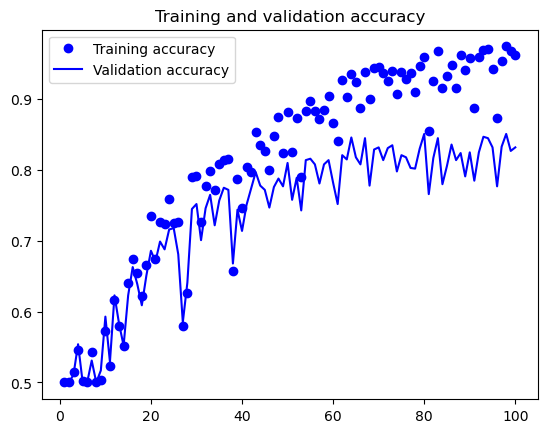

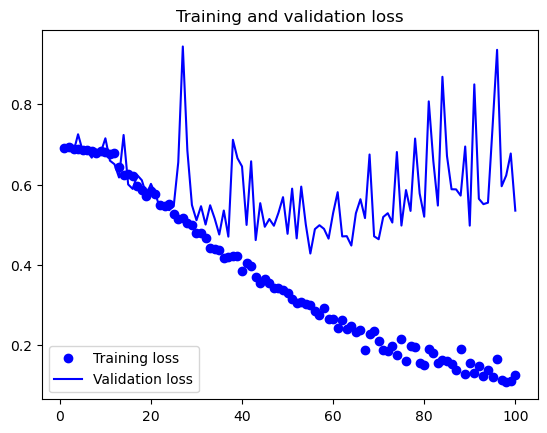

In [65]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, train_losses, "bo", label="Training loss")
plt.plot(epochs, val_losses, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

> **Figure 8.11** - Training and validation metrics with data augmentation

In [64]:
test_dataset_final = torchvision.datasets.ImageFolder(
    root=new_base_dir / "test",
    transform=val_test_transform
)
test_loader_final = DataLoader(test_dataset_final, batch_size=32, shuffle=False)

model.load_state_dict(torch.load("convnet_from_scratch_with_augmentation.pth"))
test_acc = calculate_accuracy(test_loader_final, model, device)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.803


We get a test accuracy of about 80%. It's starting to look good! If you're using Colab, make
sure you download the saved file (``convnet_from_scratch_with_augmentation.pth``),
as we will use it for some experiments in the next chapter.

By further tuning the model's configuration (such as the number of filters per
convolution layer, or the number of layers in the model), we might be able to get an
even better accuracy, likely up to 90%. But it would prove difficult to go any higher
just by training our own convnet from scratch, because we have so little data to work
with. As a next step to improve our accuracy on this problem, we'll have to use a pretrained
model, which is the focus of the next two sections.

## Leveraging a pretrained model


A common and highly effective approach to deep learning on small image datasets is
to use a pretrained model. A *pretrained model* is a model that was previously trained on
a large dataset, typically on a large-scale image-classification task. If this original dataset
is large enough and general enough, the spatial hierarchy of features learned by
the pretrained model can effectively act as a generic model of the visual world, and
hence, its features can prove useful for many different computer vision problems,
even though these new problems may involve completely different classes than those
of the original task. For instance, you might train a model on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained model for
something as remote as identifying furniture items in images. Such portability of
learned features across different problems is a key advantage of deep learning compared
to many older, shallow learning approaches, and it makes deep learning very
effective for small-data problems.

In this case, let's consider a large convnet trained on the ImageNet dataset (1.4
million labeled images and 1,000 different classes). ImageNet contains many animal
classes, including different species of cats and dogs, and you can thus expect it to perform
well on the dogs-versus-cats classification problem.

We'll use the VGG16 architecture, developed by Karen Simonyan and Andrew
Zisserman in [2014 [1]](https://arxiv.org/abs/1409.1556). Although it's an older model, far from the current state of the art and somewhat heavier than many other recent models,
I chose it because its architecture
is similar to what you're already familiar with, and it's easy to understand without
introducing any new concepts. This may be your first encounter with one of these
cutesy model names—VGG, ResNet, Inception, Xception, and so on; you'll get used
to them because they will come up frequently if you keep doing deep learning for
computer vision.

There are two ways to use a pretrained model: feature extraction and fine-tuning.
We'll cover both of them. Let's start with feature extraction.

### Feature extraction with a pretrained model


Feature extraction consists of using the representations learned by a previously
trained model to extract interesting features from new samples. These features are
then run through a new classifier, which is trained from scratch.

As you saw previously, convnets used for image classification comprise two parts:
they start with a series of pooling and convolution layers, and they end with a densely
connected classifier. The first part is called the *convolutional base* of the model. In the
case of convnets, feature extraction consists of taking the convolutional base of a previously
trained network, running the new data through it, and training a new classifier
on top of the output (see figure 8.12).

Why only reuse the convolutional base? Could we reuse the densely connected
classifier as well? In general, doing so should be avoided. The reason is that the representations
learned by the convolutional base are likely to be more generic and, therefore,
more reusable: the feature maps of a convnet are presence maps of generic
concepts over a picture, which are likely to be useful regardless of the computer vision
problem at hand. But the representations learned by the classifier will necessarily be
specific to the set of classes on which the model was trained—they will only contain
information about the presence probability of this or that class in the entire picture.
Additionally, representations found in densely connected layers no longer contain any
information about where objects are located in the input image; these layers get rid of
the notion of space, whereas the object location is still described by convolutional feature
maps. For problems where object location matters, densely connected features
are largely useless.

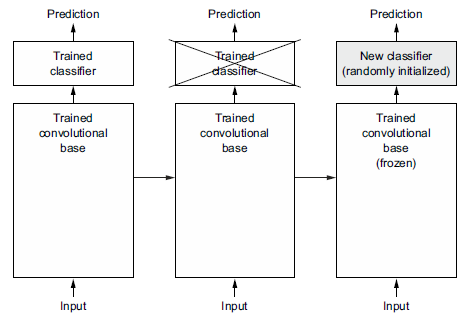

> **Figure 8.12** - Swapping classifiers while keeping the same convolutional base

Note that the level of generality (and therefore reusability) of the representations
extracted by specific convolution layers depends on the depth of the layer in the
model. Layers that come earlier in the model extract local, highly generic feature
maps (such as visual edges, colors, and textures), whereas layers that are higher up
extract more-abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset
differs a lot from the dataset on which the original model was trained, you may be better
off using only the first few layers of the model to do feature extraction, rather than
using the entire convolutional base.

In this case, because the ImageNet class set contains multiple dog and cat
classes, it's likely to be beneficial to reuse the information contained in the densely
connected layers of the original model. But we'll choose not to, in order to cover
the more general case where the class set of the new problem doesn't overlap the
class set of the original model. Let's put this into practice by using the convolutional
base of the VGG16 network, trained on ImageNet, to extract interesting features
from cat and dog images, and then train a dogs-versus-cats classifier on top of
these features.

The VGG16 model, among others, comes prepackaged with PyTorch. You can import
it from the ``torchvision.models`` module. Many other image-classification models (all
pretrained on the ImageNet dataset) are available as part of ``torchvision.models``:

- ResNet
- DenseNet
- MobileNet
- EfficientNet
- Vision Transformer
- etc.

Let's instantiate the VGG16 model.

In [9]:
import torchvision.models as models

conv_base = models.vgg16(pretrained=True).features

/home/hglps/miniconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hglps/miniconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We load the pretrained VGG16 model and only use the feature extraction part (convolutional base).
The ``.features`` attribute gives us the convolutional base without the densely connected classifier layers.
Because we intend to use our own densely connected classifier (with only two classes: ``cat`` and ``dog``), we don't need to
include the original classifier.

Here's the detail of the architecture of the VGG16 convolutional base. It's similar to
the simple convnets you're already familiar with:

In [67]:
print(conv_base)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

The final feature map has shape ``(batch_size, 512, 5, 5)`` when processing ``(180, 180)`` images. That's the feature map on top of which
we'll stick a densely connected classifier.

At this point, there are two ways we could proceed:
- Run the convolutional base over our dataset, record its output to a NumPy array
on disk, and then use this data as input to a standalone, densely connected classifier
similar to those you saw in chapter 4 of this book. This solution is fast and
cheap to run, because it only requires running the convolutional base once for
every input image, and the convolutional base is by far the most expensive part
of the pipeline. But for the same reason, this technique won't allow us to use
data augmentation.
- Extend the model we have (``conv_base``) by adding ``Linear`` layers on top, and run
the whole thing from end to end on the input data. This will allow us to use
data augmentation, because every input image goes through the convolutional
base every time it's seen by the model. But for the same reason, this technique is
far more expensive than the first.

We'll cover both techniques. Let's walk through the code required to set up the first
one: recording the output of conv_base on our data and using these outputs as inputs
to a new model.

#### FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION


We'll start by extracting features as NumPy arrays by running inference with
the ``conv_base`` model on our training, validation, and testing datasets.

Let's iterate over our datasets to extract the VGG16 features.

In [ ]:
import numpy as np
import torch

def get_features_and_labels(dataset_path, conv_base, device):
    feature_dataset = torchvision.datasets.ImageFolder(
        root=dataset_path,
        transform=transforms.Compose([
            transforms.Resize((224, 224)),  # VGG16: 224x224 images
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
    )
    
    feature_loader = DataLoader(feature_dataset, batch_size=32, shuffle=False)
    
    all_features = []
    all_labels = []
    
    conv_base.eval()
    with torch.no_grad():
        for images, labels in feature_loader:
            images = images.to(device)
            features = conv_base(images)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())
    
    return np.concatenate(all_features), np.concatenate(all_labels)

conv_base.to(device)

train_features, train_labels = get_features_and_labels(new_base_dir / "train", conv_base, device)
val_features, val_labels = get_features_and_labels(new_base_dir / "validation", conv_base, device)
test_features, test_labels = get_features_and_labels(new_base_dir / "test", conv_base, device)

Importantly, the VGG16 model expects inputs that are preprocessed with ImageNet normalization
(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) and resized to 224x224 pixels.

The extracted features are currently of shape ``(samples, 512, 7, 7)`` (assuming 224x224 input):

In [69]:
print("Train features shape:", train_features.shape)


Train features shape: (2000, 512, 7, 7)


At this point, we can define our densely connected classifier (note the use of dropout
for regularization) and train it on the data and labels that we just recorded.


In [76]:
class FeatureClassifier(nn.Module):
    def __init__(self, input_size):
        super(FeatureClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

input_size = train_features.shape[1] * train_features.shape[2] * train_features.shape[3]
feature_model = FeatureClassifier(input_size)
feature_model.to(device)

feature_criterion = nn.BCELoss()
feature_optimizer = optim.RMSprop(feature_model.parameters(), lr=0.001)

train_features_tensor = torch.from_numpy(train_features).float()
train_labels_tensor = torch.from_numpy(train_labels).float()
val_features_tensor = torch.from_numpy(val_features).float()
val_labels_tensor = torch.from_numpy(val_labels).float()

feature_train_dataset = torch.utils.data.TensorDataset(train_features_tensor, train_labels_tensor)
feature_val_dataset = torch.utils.data.TensorDataset(val_features_tensor, val_labels_tensor)

feature_train_loader = DataLoader(feature_train_dataset, batch_size=32, shuffle=True)
feature_val_loader = DataLoader(feature_val_dataset, batch_size=32, shuffle=False)

best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(20):
    feature_model.train()
    running_loss = 0.0
    
    correct_train = 0
    total_train = 0
    for features, labels in feature_train_loader:
        features, labels = features.to(device), labels.to(device)
        
        feature_optimizer.zero_grad()
        outputs = feature_model(features).squeeze()
        loss = feature_criterion(outputs, labels)
        loss.backward()
        feature_optimizer.step()
        
        running_loss += loss.item()
        
        predicted_train = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_acc = correct_train / total_train
    
    feature_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in feature_val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = feature_model(features).squeeze()
            loss = feature_criterion(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(feature_train_loader)
    val_loss = val_loss / len(feature_val_loader)
    val_acc = correct / total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/20, Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(feature_model.state_dict(), "feature_extraction.pth")


Epoch 1/20, Train Loss: 4.1104, Val Loss: 0.6344, Val Acc: 0.9820
Epoch 2/20, Train Loss: 0.7331, Val Loss: 0.4034, Val Acc: 0.9850
Epoch 3/20, Train Loss: 0.7694, Val Loss: 0.5414, Val Acc: 0.9830
Epoch 4/20, Train Loss: 0.2889, Val Loss: 0.6588, Val Acc: 0.9730
Epoch 5/20, Train Loss: 0.4254, Val Loss: 0.4659, Val Acc: 0.9840
Epoch 6/20, Train Loss: 0.2442, Val Loss: 0.6228, Val Acc: 0.9860
Epoch 7/20, Train Loss: 0.3109, Val Loss: 0.3925, Val Acc: 0.9800
Epoch 8/20, Train Loss: 0.2320, Val Loss: 0.2807, Val Acc: 0.9820
Epoch 9/20, Train Loss: 0.2039, Val Loss: 0.6394, Val Acc: 0.9800
Epoch 10/20, Train Loss: 0.1168, Val Loss: 0.9285, Val Acc: 0.9810
Epoch 11/20, Train Loss: 0.1112, Val Loss: 0.5199, Val Acc: 0.9820
Epoch 12/20, Train Loss: 0.1114, Val Loss: 1.0688, Val Acc: 0.9830
Epoch 13/20, Train Loss: 0.1095, Val Loss: 0.6398, Val Acc: 0.9840
Epoch 14/20, Train Loss: 0.1025, Val Loss: 0.5800, Val Acc: 0.9850
Epoch 15/20, Train Loss: 0.0995, Val Loss: 0.5122, Val Acc: 0.9830
Epoc

Training is very fast because we only have to deal with two ``Linear`` layers—an epoch
takes less than one second even on CPU.

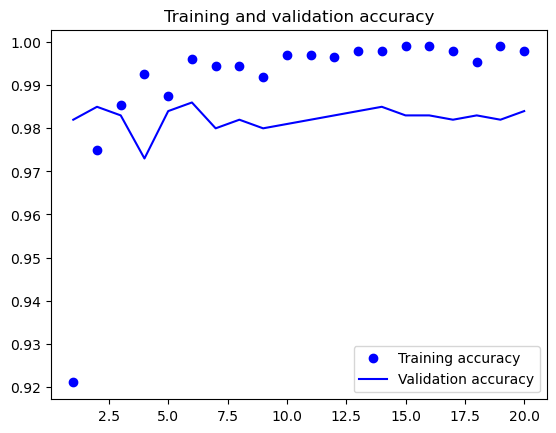

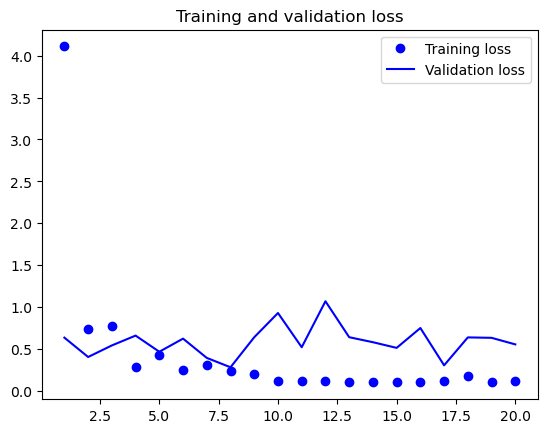

In [79]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, train_losses, "bo", label="Training loss")
plt.plot(epochs, val_losses, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

> **Figure 8.13** - Training and validation metrics for plain feature extraction

Let's look at the loss and accuracy curves during training (see figure 8.13).


We reach a validation accuracy of about 97%—much better than we achieved in the
previous section with the small model trained from scratch. This is a bit of an unfair
comparison, however, because ImageNet contains many dog and cat instances, which
means that our pretrained model already has the exact knowledge required for the
task at hand. This won't always be the case when you use pretrained features.

However, the plots also indicate that we're overfitting almost from the start—
despite using dropout with a fairly large rate. That's because this technique doesn't
use data augmentation, which is essential for preventing overfitting with small image
datasets.

#### FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION


Now let's review the second technique I mentioned for doing feature extraction,
which is much slower and more expensive, but which allows us to use data augmentation
during training: creating a model that chains the ``conv_base`` with a new dense
classifier, and training it end to end on the inputs.

In order to do this, we will first *freeze the convolutional base*. Freezing a layer or set of
layers means preventing their weights from being updated during training. If we don't
do this, the representations that were previously learned by the convolutional base will
be modified during training. Because the ``Linear`` layers on top are randomly initialized,
very large weight updates would be propagated through the network, effectively
destroying the representations previously learned.

In PyTorch, we freeze a layer or model by setting the ``requires_grad`` attribute of its parameters to ``False``.

In [10]:
conv_base = models.vgg16(pretrained=True).features

for param in conv_base.parameters():
    param.requires_grad = False

Setting ``requires_grad`` to ``False`` prevents the parameters from being updated during training.

In [90]:
trainable_params = sum(p.numel() for p in conv_base.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in conv_base.parameters())

print(f"Trainable parameters in conv_base: {trainable_params}")
print(f"Total parameters in conv_base: {total_params}")

Trainable parameters in conv_base: 0
Total parameters in conv_base: 14714688


Now we can create a new model that chains together
1. A data augmentation stage (applied through transforms)
2. Our frozen convolutional base
3. A dense classifier

In [12]:
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, conv_base):
        super(VGG16FeatureExtractor, self).__init__()
        self.conv_base = conv_base
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_base(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model = VGG16FeatureExtractor(conv_base)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

train_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=36),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_test_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

train_dataset_vgg = torchvision.datasets.ImageFolder(
    root=new_base_dir / "train",
    transform=train_transform_vgg
)

validation_dataset_vgg = torchvision.datasets.ImageFolder(
    root=new_base_dir / "validation",
    transform=val_test_transform_vgg
)

train_loader_vgg = DataLoader(train_dataset_vgg, batch_size=32, shuffle=True)
validation_loader_vgg = DataLoader(validation_dataset_vgg, batch_size=32, shuffle=False)


With this setup, only the weights from the classifier layers that we added will be
trained. Note that in PyTorch, you need to make sure that only the parameters with
``requires_grad=True`` are passed to the optimizer, or set ``requires_grad=False`` before
creating the optimizer.

Let's train our model. Thanks to data augmentation, it will take much longer for
the model to start overfitting, so we can train for more epochs—let's do 50.

> **NOTE** This technique is expensive enough that you should only attempt it if
> you have access to a GPU (such as the free GPU available in Colab)—it's
> intractable on CPU. If you can't run your code on GPU, then the previous
> technique is the way to go.

In [13]:
best_val_loss = float('inf')

def calculate_accuracy_vgg(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(50):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader_vgg:
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader_vgg)
    
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader_vgg:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(validation_loader_vgg)
        
    # if (epoch + 1) % 5 == 0:
    train_acc = calculate_accuracy_vgg(train_loader_vgg, model, device)
    val_acc = calculate_accuracy_vgg(validation_loader_vgg, model, device)
    print(f'Epoch {epoch+1}/50, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "feature_extraction_with_data_augmentation.pth")


Epoch 1/50, Train Loss: 7.3175, Train Acc: 0.9045, Val Loss: 4.8583, Val Acc: 0.9310
Epoch 2/50, Train Loss: 4.8181, Train Acc: 0.9535, Val Loss: 1.5415, Val Acc: 0.9730
Epoch 3/50, Train Loss: 3.3151, Train Acc: 0.9170, Val Loss: 1.2633, Val Acc: 0.9720
Epoch 4/50, Train Loss: 4.3384, Train Acc: 0.9670, Val Loss: 1.2967, Val Acc: 0.9800
Epoch 5/50, Train Loss: 3.2052, Train Acc: 0.9480, Val Loss: 1.3285, Val Acc: 0.9730
Epoch 6/50, Train Loss: 3.4413, Train Acc: 0.9595, Val Loss: 1.5952, Val Acc: 0.9730
Epoch 7/50, Train Loss: 2.3845, Train Acc: 0.9580, Val Loss: 1.6041, Val Acc: 0.9760
Epoch 8/50, Train Loss: 2.9113, Train Acc: 0.9630, Val Loss: 1.3135, Val Acc: 0.9810
Epoch 9/50, Train Loss: 3.0235, Train Acc: 0.9415, Val Loss: 1.8541, Val Acc: 0.9730
Epoch 10/50, Train Loss: 2.5103, Train Acc: 0.9720, Val Loss: 1.4084, Val Acc: 0.9800
Epoch 11/50, Train Loss: 2.3435, Train Acc: 0.9685, Val Loss: 1.5814, Val Acc: 0.9770
Epoch 12/50, Train Loss: 2.2996, Train Acc: 0.9595, Val Loss: 1

Let's plot the results again (see figure 8.14). As you can see, we reach a validation
accuracy of over 98%. This is a strong improvement over the previous model.

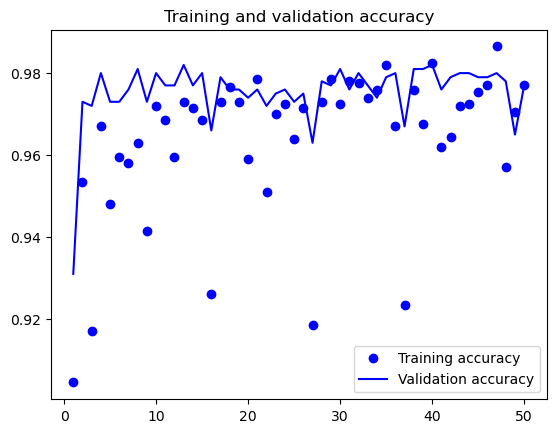

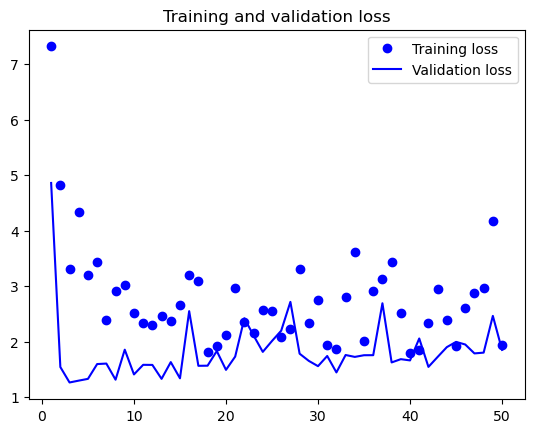

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, train_losses, "bo", label="Training loss")
plt.plot(epochs, val_losses, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Let's check the test accuracy.


In [15]:
test_dataset_vgg = torchvision.datasets.ImageFolder(
    root=new_base_dir / "test",
    transform=val_test_transform_vgg
)
test_loader_vgg = DataLoader(test_dataset_vgg, batch_size=32, shuffle=False)

model.load_state_dict(torch.load("feature_extraction_with_data_augmentation.pth"))
test_acc = calculate_accuracy_vgg(test_loader_vgg, model, device)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.967


We get a test accuracy of 96.7%. This is only a modest improvement compared to the
previous test accuracy, which is a bit disappointing given the strong results on the validation
data. A model's accuracy always depends on the set of samples you evaluate it
on! Some sample sets may be more difficult than others, and strong results on one set
won't necessarily fully translate to all other sets.

### Fine-tuning a pretrained model


Another widely used technique for model reuse,
complementary to feature extraction, is *fine-tuning*
(see figure 8.15). Fine-tuning consists of unfreezing
a few of the top layers of a frozen model base used
for feature extraction, and jointly training both the
newly added part of the model (in this case, the
fully connected classifier) and these top layers. This
is called *fine-tuning* because it slightly adjusts the
more abstract representations of the model being
reused in order to make them more relevant for the
problem at hand.

I stated earlier that it's necessary to freeze the
convolution base of VGG16 in order to be able to
train a randomly initialized classifier on top. For the
same reason, it's only possible to fine-tune the top
layers of the convolutional base once the classifier on
top has already been trained. If the classifier isn't
already trained, the error signal propagating
through the network during training will be too
large, and the representations previously learned by
the layers being fine-tuned will be destroyed. Thus
the steps for fine-tuning a network are as follows:

1. Add our custom network on top of an
already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.
(Note that you should not unfreeze "batch
normalization" layers, which are not relevant
here since there are no such layers in VGG16.
Batch normalization and its impact on finetuning
is explained in the next chapter.)
5. Jointly train both these layers and the part we
added.

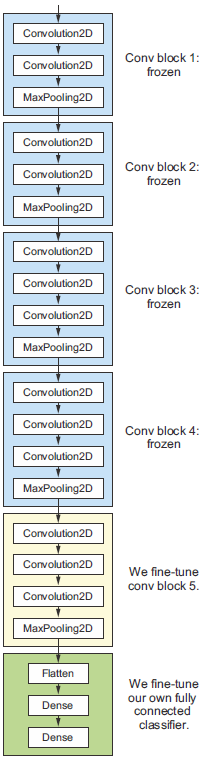

> **Figure 8.15** - Fine-tuning the last convolutional block of the VGG16 network

You already completed the first three steps when
doing feature extraction. Let's proceed with step 4:
we'll unfreeze our ``conv_base`` and then freeze individual
layers inside it.

As a reminder, this is what our convolutional base looks like:

In [16]:
print(conv_base)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

We'll fine-tune the last three convolutional layers, which means all layers up to the fourth
max pooling layer should be frozen, and the last convolutional block should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base?
You could. But you need to consider the following:

- Earlier layers in the convolutional base encode more generic, reusable features,
whereas layers higher up encode more specialized features. It's more useful to
fine-tune the more specialized features, because these are the ones that need
to be repurposed on your new problem. There would be fast-decreasing returns
in fine-tuning lower layers.
- The more parameters you're training, the more you're at risk of overfitting.
The convolutional base has 15 million parameters, so it would be risky to
attempt to train it on your small dataset.

Thus, in this situation, it's a good strategy to fine-tune only the top two or three layers
in the convolutional base. Let's set this up, starting from where we left off in the previous
example.

In [20]:
for param in conv_base.parameters():
    param.requires_grad = True

layers_list = list(conv_base.children())
layers_to_freeze = layers_list[:-4]

# Freeze all but the last 4 layers
for layer in layers_to_freeze:
    for param in layer.parameters():
        param.requires_grad = False


Now we can begin fine-tuning the model. We'll do this with the RMSprop optimizer,
using a very low learning rate. The reason for using a low learning rate is that we want to
limit the magnitude of the modifications we make to the representations of the three
layers we're fine-tuning. Updates that are too large may harm these representations.


In [ ]:
fine_tune_optimizer = optim.RMSprop(model.parameters(), lr=1e-5)

best_val_loss = float('inf')

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_vgg:
        inputs, labels = inputs.to(device), labels.float().to(device)
        
        fine_tune_optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        fine_tune_optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader_vgg)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader_vgg:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(validation_loader_vgg)
    
    if (epoch + 1) % 5 == 0:
        train_acc = calculate_accuracy_vgg(train_loader_vgg, model, device)
        val_acc = calculate_accuracy_vgg(validation_loader_vgg, model, device)
        print(f'Epoch {epoch+1}/30, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "fine_tuning.pth")

Epoch 5/30, Train Loss: 1.3731, Train Acc: 0.9720, Val Loss: 0.7016, Val Acc: 0.9800
Epoch 10/30, Train Loss: 0.6393, Train Acc: 0.9810, Val Loss: 0.6282, Val Acc: 0.9820
Epoch 15/30, Train Loss: 0.5373, Train Acc: 0.9825, Val Loss: 0.5296, Val Acc: 0.9840
Epoch 20/30, Train Loss: 0.5418, Train Acc: 0.9850, Val Loss: 0.6283, Val Acc: 0.9820
Epoch 25/30, Train Loss: 0.5186, Train Acc: 0.9835, Val Loss: 0.6096, Val Acc: 0.9830
Epoch 30/30, Train Loss: 0.6222, Train Acc: 0.9915, Val Loss: 0.5224, Val Acc: 0.9820


We can finally evaluate this model on the test data:


In [22]:
model.load_state_dict(torch.load("fine_tuning.pth"))
test_acc = calculate_accuracy_vgg(test_loader_vgg, model, device)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.984


Here, we get a test accuracy of 98% (again, your own results may be within one percentage
point). In the original Kaggle competition around this dataset, this would
have been one of the top results. It's not quite a fair comparison, however, since we
used pretrained features that already contained prior knowledge about cats and dogs,
which competitors couldn't use at the time.

On the positive side, by leveraging modern deep learning techniques, we managed
to reach this result using only a small fraction of the training data that was available
for the competition (about 10%). There is a huge difference between being able to
train on 20,000 samples compared to 2,000 samples!

Now you have a solid set of tools for dealing with image-classification problems—in
particular, with small datasets.

> ## Summary
> - Convnets are the best type of machine learning models for computer vision
> tasks. It's possible to train one from scratch even on a very small dataset, with
> decent results.
> - Convnets work by learning a hierarchy of modular patterns and concepts to
> represent the visual world.
> - On a small dataset, overfitting will be the main issue. Data augmentation is a
> powerful way to fight overfitting when you're working with image data.
> - It's easy to reuse an existing convnet on a new dataset via feature extraction.
> This is a valuable technique for working with small image datasets.
> - As a complement to feature extraction, you can use fine-tuning, which adapts to
> a new problem some of the representations previously learned by an existing
> model. This pushes performance a bit further.